In [1]:
!pip install mss
!pip install matplotlib
!pip install tensorboardX python-dotenv


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [3]:
import os
from dotenv import load_dotenv

EXECUTABLE_NAME = os.getenv('EXECUTABLE_NAME')
GAME_WINDOW_NAME = os.getenv('GAME_WINDOW_NAME')

### camera

In [4]:
from src.gamenv import GameEnv

game_env = GameEnv("snes9x.exe", "mario - Snes9x 1.62.3", (100, 200, -10, -20))
camera = game_env.camera

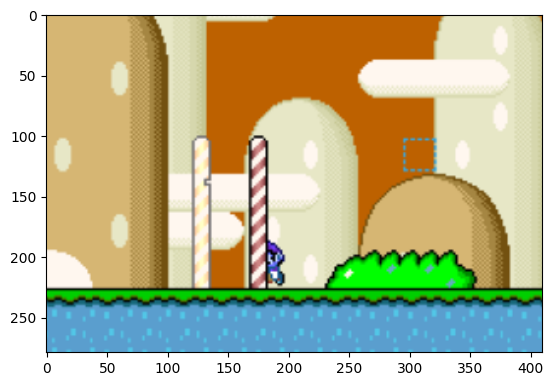

In [5]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)

### Agent

In [6]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
D = 10_000
GAMMA = 0.99
LR = 0.00003

NUM_EPISODES = 5000
SEQUENCE_LENGTH = 10
BATCH_SIZE = 32

EPS_NUM_STEPS = 1500
EPS_START = 0.99
EPS_END = 0.03
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)


action_space = 4

load_model = False
model_name = "2023_12_19_14_01_33"

In [8]:
import time
from itertools import count
from tensorboardX import SummaryWriter

from src.memory import Memory

timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

In [9]:

# Initiliaze replay memory D to capacity N
replay_memory = Memory(D)
sequence = Memory(SEQUENCE_LENGTH)

In [10]:
from src.models.batch_model import DQN, phi
from torch import nn

# Initialize action-value function Q with random weights

lstm_n = 256
lstm_layers = 2

policy_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta
target_net = DQN(action_space, lstm_n, lstm_layers).to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()

steps = 0
episode = 0
epsilon = EPS_START

In [11]:
time.sleep(2)
camera.set_foreground_game()
time.sleep(0.2)

with SummaryWriter(logdir="runs/"+timestr) as writer:
    
    while steps < D-50:
        
        ep_rewards = 0
        ep_qvalues = 0
        ep_loss = 0
        
        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        observation = game_env.reset()
        state = phi(observation, device)
        last_reward = 0
        sequence.clear()
        
        
        for t in count():

            sequence.push(state)
            sequence_state = sequence.render_simple()

            hn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)
            cn = torch.zeros(lstm_layers, lstm_n, dtype=torch.float32, device=device)

            with torch.no_grad():
                
                q_value_action, (hn, cn) = policy_net(sequence_state, (hn, cn))
                q_value_action = q_value_action[-1:]
                q_value_action = q_value_action.max(1)
                q_value = q_value_action[0].item()
                ep_qvalues += q_value
                
            
            # With probability eps select a random action at
            epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
            if random.uniform(0, 1) < epsilon:
                action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
            # otherwise select at = maxaQ*(phi(st), a; teta)
            else:
                action = q_value_action[1].view(1,1)
                print(action)

            # Execute action at in emulator and observe reward rt and image xt+1
            observation, reward, game_over = game_env.step(action.item())
            
            ep_rewards += reward
            reward = torch.tensor([reward], device=device, dtype=torch.float32)

            # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
            if game_over:
                next_state = None # ordem provavelmente errada
            else:
                next_state = phi(observation, device)
                # sequence.push(next_state)
                # rendered, next_sequence_state = sequence.render()

            #if sequence_state != None:
            #    replay_memory.push((sequence_state, action, reward, next_sequence_state))
            replay_memory.push((state, action, reward, next_state))
            
            if len(replay_memory) > BATCH_SIZE and steps > 50:
                loss = policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample(BATCH_SIZE), GAMMA, lstm_n, lstm_layers, device).item()
                ep_loss += loss
                if t % 150 == 0:

                    clear_output(wait=True)
                    print('loss:', ep_loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', ep_rewards, 'ep:', episode)

                    writer.add_scalar("Loss/ep_loss", ep_loss, steps)
                    writer.add_scalar("Reward/ep_rewards", ep_rewards, steps)
                    writer.add_scalar("Qvalue/ep_qvalues", ep_qvalues, steps)

                    ep_rewards = 0
                    ep_qvalues = 0
                    ep_loss = 0

                writer.add_scalar("Loss/loss", loss, steps)
                writer.add_scalar("Reward/reward", reward, steps)
                writer.add_scalar("Qvalue/qvalue", q_value, steps)
                writer.flush()
                
                if t % 300 == 0:
                    target_net.load_state_dict(policy_net.state_dict())
                    
            # sequence_state = next_sequence_state 
            state = next_state
            steps += 1
            if game_over:
                break
        episode += 1
        # writer.flush()

loss: 15.390006065368652 step: 4943 epsilon: 0.03 last_reward: 1 ep: 175
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')


In [12]:
camera.set_foreground_game()
while True:
    
    observation = game_env.reset()
    time.sleep(0.1)
    state = phi(observation, device)
    sequence.clear()
    sequence.push(state)
    
    rendered, sequence_state = sequence.render()
    
    for t in count():

        hn = torch.zeros(lstm_layers, 1, lstm_n, dtype=torch.float32, device=device)
        cn = torch.zeros(lstm_layers, 1, lstm_n, dtype=torch.float32, device=device)
        with torch.no_grad():
            if rendered:
                q_value_action, hn, cn = policy_net(sequence_state.unsqueeze(0), hn, cn)
                q_value_action = q_value_action.max(1)
                action = q_value_action[1].view(1,1)
            else:
                action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)      
        print(action)
        observation, reward, game_over = game_env.step(action.item())
        if game_over:
            next_state = None # ordem provavelmente errada
        else:
            next_state = phi(observation, device)
            sequence.push(next_state)
            rendered, next_sequence_state = sequence.render()
        sequence_state = next_sequence_state
        if game_over:
            break

tensor([[2]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[0]], device='cuda:0')
tensor([[0]], device='cuda:0')


TypeError: DQN.forward() takes 3 positional arguments but 4 were given

In [ ]:

import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')